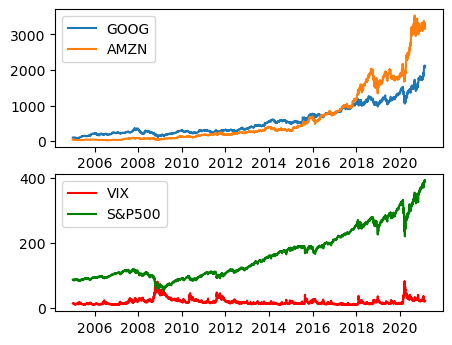

In [3]:
#Importar librerias, datos y visualizacion 
import pandas as pd
from pandas_datareader import wb
from datetime import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
import numpy as np
from math import log, sqrt
import random

from datetime import date

start = datetime(2005, 1, 1)
end = date.today()



tickers = ['spy','GOOG', 'AMZN','^VIX']
data = web.get_data_yahoo(tickers, start, end)

vix = data['Adj Close']['^VIX']
spy = data['Adj Close']['spy']
goog = data['Adj Close']['GOOG']
amzn = data['Adj Close']['AMZN']

plt.figure(figsize=(5,4),dpi=100) 
plt.subplots_adjust(wspace=0.9)
plt.subplot(2,1,1)
plt.plot(goog)
plt.plot(amzn)
plt.legend(['GOOG','AMZN'])
plt.subplot(2,1,2)
plt.plot(vix,color ="red")
plt.plot(spy,color ='green')
plt.legend(['VIX','S&P500'])


In [4]:
#ECONOMETRIC ANALYSIS: VIX and S&P 500

from rpy2.robjects import r
from rpy2.robjects.packages import importr
import numpy as np
from rpy2.robjects import numpy2ri
numpy2ri.activate()

#split data
vix = data['Adj Close']['^VIX'][0:3245].to_numpy()
spy = data['Adj Close']['spy'][0:3245].to_numpy()
vix_test = data['Adj Close']['^VIX'][3245:].to_numpy()
spy_test = data['Adj Close']['spy'][3245:].to_numpy()

def get_returns(x):
    x_t_0 = x[0:-1]
    x_t_1 = x[1:]
    ret_log =np.log(x_t_1/x_t_0)
    return ret_log
    
r_vix = get_returns(vix)
r_spy = get_returns(spy)
r_test_vix = get_returns(vix_test)
r_test_spy = get_returns(spy_test)



In [6]:
# R LIBRERIES
forecast = importr('forecast')
tseries=importr('tseries')
fGarch=importr('fGarch')
rugarch=importr('rugarch')
stochvol=importr('stochvol')
tsDyn=importr('tsDyn')
timeSeries=importr('timeSeries')
nnet=importr('nnet')
TSA=importr('TSA')

#Assign a variable for returns in r 
r.assign('x', r_vix)
r.assign('y',r_spy)
#Summary, Stationary, autocorrelation
summ = r('summary(x)')
adf = r('adf.test(x)')
acf = r('acf(x)')

print(summ)
print(adf)
print(acf)



      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.3505885 -0.0395795 -0.0052110 -0.0000861  0.0336105  0.4960079 


	Augmented Dickey-Fuller Test

data:  x
Dickey-Fuller = -17.664, Lag order = 14, p-value = 0.01
alternative hypothesis: stationary



Autocorrelations of series ‘x’, by lag

     1      2      3      4      5      6      7      8      9     10     11 
-0.096 -0.056 -0.029 -0.037 -0.033 -0.027 -0.034 -0.014 -0.022  0.056  0.006 
    12     13     14     15     16     17     18     19     20     21     22 
-0.021 -0.018 -0.006 -0.036  0.021  0.023 -0.013 -0.007  0.016  0.001  0.006 
    23     24     25     26     27     28     29     30     31     32     33 
 0.005 -0.002  0.000 -0.031  0.010 -0.007 -0.050  0.000 -0.001 -0.025 -0.003 
    34     35 
-0.019  0.000 



In [25]:
#Fit: Garch(1,1) model
garch_1_1 = r('garchFit(~garch(1,1),data=x,cond.dist = "std")')
r.assign('GARCH11', garch_1_1)

#Return prediction
nfore= len(vix_test) 
r.assign('nFore', nfore)
prevr= r_vix[-1] 


spec=r('garchSpec(list(mu = -0.0008606519,omega=0.0005554687,alpha =0.1624078142 , beta =  0.7407501113))')
r.assign('spec', spec) 
SimGarch=r('garchSim(spec,n = nFore)')
pred_r_garch = r('predict(GARCH11,nFore,conf = 0.95)')
r.assign('predRGARCH11',pred_r_garch )

#SPOT PREDICTION
prevspot=vix[-1] 
prevspot=vix[-1] 
predspot_Garch = []

for i in range(nfore):
    predspot_Garch.append(prevspot * np.exp(SimGarch[i]))
    prevspot = predspot_Garch[i]



Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(1, 1)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               1 1
 Max GARCH Order:           1
 Maximum Order:             1
 Conditional Dist:          std
 h.start:                   2
 llh.start:                 1
 Length of Series:          3244
 Recursion Init:            mci
 Series Scale:              0.07173942

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U            V       params includes
    mu     -0.01199692   0.01199692 -0.001199692     TRUE
    omega   0.00000100 100.00000000  0.100000000     TRUE
    alpha1  0.00000001   0.99999999  0.100000000     TRUE
    gamma1 -0.99999999   0.99999999  0.100000000    FALSE
    beta1   0.00000001   

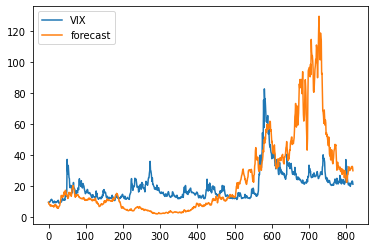

In [26]:
#VIX vs forecast
plt.plot(vix_test)
plt.plot(predspot_Garch)
plt.legend(['VIX','forecast'])
plt.show()
